In [1]:
import pickle
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
#print(tf.version)
import bz2
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
from sklearn import metrics
import seaborn as sns
import itertools
warnings.filterwarnings('ignore')

In [2]:
import os
import os.path
from glob import glob
import random
import shutil
from tqdm.auto import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
#from kerashypetune import KerasGridSearch

In [3]:
def FIPS_function(row):
    state = str(row['stateFip']).zfill(2)
    county = str(row['countyFip']).zfill(3)
    return str(state + county)

def get_above_threshold(dff,thresh):
    corr_mtrx = dff.corr()
    corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns)
    numCols = corr_mtrx.shape[0]
    above_threshold = []
    
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] > thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    return above_threshold

def get_below_threshold(dff,thresh):
    corr_mtrx = dff.corr()
    corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns)
    numCols = corr_mtrx.shape[0]
    above_threshold = []
    
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] < thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    return above_threshold

In [4]:
filee = '/Users/evanfalkowski/Documents/Drexel/Capstone/DSCI_592/workspace/feeFiFoFum.pbz2'
bz_file = bz2.BZ2File(filee,'rb'); og_df = pd.read_pickle(bz_file); df = og_df.copy()
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']
df.drop(cols, axis=1, inplace=True); df.head(3)

,dates,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,...,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25
0,2020-03-19,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
1,2020-03-20,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551
2,2020-03-21,1.0,0.0,24527.0,5343.0,11868.0,12673.0,4924.0,9716.5,0.0,...,38.1,12191,24397,21415,179,87,39,122,2555,9.618551


# ------------- Clean up -----------

In [5]:
### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county
counties = pd.read_csv('2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'longitude',
                    'INTPTLAT': 'latitude'}, inplace=True)

counties = counties[['GEOID', 'latitude', 'longitude' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

### Replace dates with monotonically increasing integers starting with the minimum date
df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
#print(min_date, max_date, df.dates.dtype)
df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

###Replace the integer representation of date with sin and cosine encoding
cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

###Get the feature column for latitude and longitude
# crossed_latlong = pp.get_latlong_fc(df)
lat_buckets = list(np.linspace(df.latitude.min(), df.latitude.max(),100))
long_buckets = list(np.linspace(df.longitude.min(), df.longitude.max(),100))

#make feature columns
lat_fc = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'),lat_buckets)
long_fc= tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),long_buckets)
    
# crossed columns tell the model how the features relate
crossed_latlong = tf.feature_column.crossed_column(keys=[lat_fc, long_fc], hash_bucket_size=1000) # No precise rule, maybe 1000 buckets will be good?    
embedded_latlong = tf.feature_column.embedding_column(crossed_latlong,9)
feature_layer = tf.keras.layers.DenseFeatures(embedded_latlong)
df[['geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']] = feature_layer({'latitude': df.latitude, 'longitude': df.longitude})
# df.drop(['longitude', 'latitude'], axis=1, inplace=True)

##### normalize the data
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25', 'latitude',
       'longitude']
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos', 'geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)
df.head(1)

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,-0.381945,-0.108293,0.135089,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


In [6]:
print(df.isnull().sum().sum())

380


In [7]:
df_pca = df.dropna()
df_pca = df_pca.reset_index(drop = True)
df_pca.head(1)

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,-0.381945,-0.108293,0.135089,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


In [8]:
print(df.shape[0]);print(df_pca.shape[0])

1879589
1879209


In [9]:
df_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
fips,1879209.0,30579.048130,15018.652531,1001.000000,19023.000000,29183.000000,45085.000000,5.604500e+04
JHU_ConfirmedCases.data,1879209.0,6899.691282,29914.277806,0.000000,223.000000,1233.000000,4207.000000,2.257502e+06
JHU_ConfirmedDeaths.data,1879209.0,119.312685,512.489849,0.000000,4.000000,24.000000,78.000000,2.805900e+04
cyclical_sin,1879209.0,0.043129,0.748552,-0.999991,-0.790946,0.213521,0.780296,9.999907e-01
cyclical_cos,1879209.0,-0.030722,0.660959,-0.999963,-0.658402,-0.047321,0.570242,1.000000e+00
...,...,...,...,...,...,...,...,...
healthInsForeignNoncitNo,1879209.0,0.000030,1.000099,-0.150466,-0.148931,-0.141816,-0.105963,3.202067e+01
healthInsNativeNo,1879209.0,0.000067,1.000090,-0.331952,-0.286493,-0.220357,-0.062292,2.447283e+01
pm25,1879209.0,0.000242,0.999957,-2.750077,-0.786314,0.234586,0.779634,2.258137e+00
latitude,1879209.0,0.000268,0.999924,-2.616925,-0.747148,0.010877,0.711157,2.190677e+00


In [10]:
###https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
### PCA

target = 'JHU_ConfirmedCases.data'
features = list(df_pca.columns) #;features.remove(target)
feature_columns = [tf.feature_column.numeric_column(i) for i in features]

x_p = df_pca.loc[:, features].values
x_p = StandardScaler().fit_transform(x_p)
y_p = df_pca.loc[:,[target]].values

pca = PCA(n_components=0.95)
principalComponents = pca.fit_transform(x_p)
principalDf = pd.DataFrame(data = principalComponents)

pca_df = pd.concat([principalDf, df_pca[[target]]], axis = 1)
pca_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,JHU_ConfirmedCases.data
0,-1.550551,-1.072451,-1.417797,-0.727893,0.594966,0.670176,0.153327,-0.258563,-0.808457,-0.530779,...,-0.172026,0.128342,-0.008998,0.465886,1.252038,1.714048,0.111361,-0.140754,0.720709,1.0
1,-1.542060,-0.967896,-1.318382,-0.730219,0.358109,0.776720,0.194117,0.098944,-0.319522,-0.391250,...,-0.224153,0.100632,0.059584,0.455871,1.539209,1.428966,0.371349,-0.169345,0.683436,1.0
2,-1.541292,-0.884436,-1.217625,-0.697327,0.281820,0.837803,0.187934,0.107785,-0.391320,-0.413486,...,-0.237587,0.146271,0.081095,0.462516,1.602809,1.310731,0.555435,-0.194660,0.620979,1.0


In [11]:
var_expln = list(pca.explained_variance_ratio_)
var_expln.sort(reverse=True)
var_expln[0:5]

[0.3636190605260691,
 0.06118104819316829,
 0.050418805599606153,
 0.04835783631618593,
 0.03571810560191226]

Text(0, 0.5, 'pc-2')

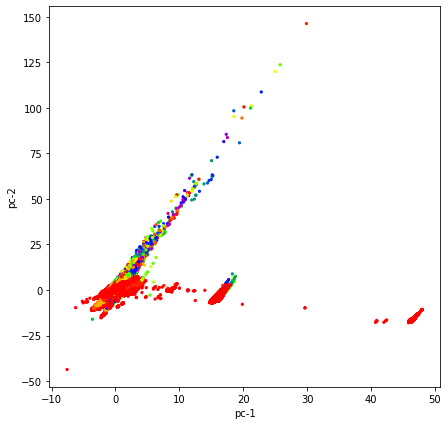

In [12]:
plt.figure(figsize=(7,7))
plt.scatter(pca_df[1],pca_df[2],c=pca_df['JHU_ConfirmedCases.data'],cmap='prism', s =5)
plt.xlabel('pc-1')
plt.ylabel('pc-2')

In [32]:
pca_corrs = get_above_threshold(df_pca,0.5); pca_corrs[0:10]

[['unitsInStructure', 'healthInsTotal', 0.9941296141854391],
 ['unitsInStructure', 'healthInsNativeWith', 0.9949703738285525],
 ['unitsInStructure', 'healthInsNativeNo', 0.89413704666801],
 ['unitsInStructure', 'healthInsForeignNoncitWith', 0.8976750800687506],
 ['unitsInStructure', 'healthInsForeignNoncitNo', 0.8614345327421726],
 ['unitsInStructure', 'healthInsForeignNatWith', 0.8757814452230246],
 ['unitsInStructure', 'healthInsForeignNatNo', 0.8839194897990456],
 ['totalTrans', 'unitsInStructure', 0.9929803057866304],
 ['totalTrans', 'householdsTotal', 0.9963845125619862],
 ['totalTrans', 'householdStructuresTotal', 0.9963845125619862]]

In [33]:
#plt.style.use('seaborn-whitegrid'); pca_df.hist(bins=5,figsize=(60,40), color='lightblue', edgecolor = 'red'); plt.show()

In [34]:
listtt = []
for i in pca_corrs:
    if i[0] == target:
        listtt.append(i)
    if i[1] == target:
        listtt.append(i)

In [37]:
len(listtt)

42

In [38]:
suggestion = []
for i in listtt:
    suggestion.append(i[1])
len(suggestion)

42

In [39]:
suggestion

['unitsInStructure',
 'totalTrans',
 'totalMoved',
 'publicTrans',
 'movedWithoutState',
 'movedWithinState',
 'movedFromAbroad',
 'latestTotalPopulation',
 'jhu_daily_new_cases_rolling_7',
 'jhu_daily_new_cases_rolling_30',
 'jhu_daily_death_rolling_30',
 'jhu_daily_cases_rolling_7',
 'jhu_daily_cases_rolling_30',
 'householdsTotal',
 'householdStructuresTotal',
 'houseWith65',
 'houseNonfamNo65',
 'houseNonfam65',
 'houseNo65',
 'houseFamilyNo65',
 'houseFamily65',
 'house2+with65',
 'house2+No65',
 'hospitalStaffedBeds',
 'hospitalLicensedBeds',
 'hospitalIcuBeds',
 'healthInsTotal',
 'healthInsNativeWith',
 'healthInsNativeNo',
 'healthInsForeignNoncitWith',
 'healthInsForeignNoncitNo',
 'healthInsForeignNatWith',
 'healthInsForeignNatNo',
 'TotalPopulation.data',
 'Male_Total_Population.data',
 'MaleAndFemale_Under18_Population.data',
 'MaleAndFemale_AtLeast65_Population.data',
 'JHU_ConfirmedDeaths.data',
 'Female_Total_Population.data',
 'BLS_UnemployedPopulation.data',
 'BLS_La

In [36]:
#########

In [16]:
pca_corrs[0][0]

'unitsInStructure'

In [16]:
pca_ = PCA(n_components=2)
pComponents = pca_.fit_transform(x_p)
pDf = pd.DataFrame(data = pComponents, columns = ['pc1', 'pc2'])
fDf = pd.concat([pDf, df_pca[[target]]], axis = 1)

In [17]:
fDf.head(3)

,pc1,pc2,JHU_ConfirmedCases.data
0,-1.538864,-1.045962,1.0
1,-1.530301,-0.941698,1.0
2,-1.529582,-0.858673,1.0


Text(0, 0.5, 'pc-2')

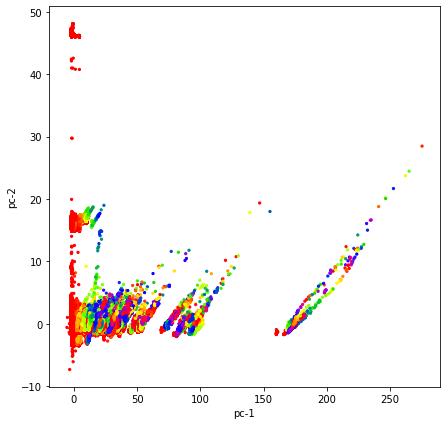

In [18]:
plt.figure(figsize=(7,7))
plt.scatter(fDf['pc1'],fDf['pc2'],c=fDf[target],cmap='prism', s =5)
plt.xlabel('pc-1')
plt.ylabel('pc-2')

In [19]:
####

In [20]:
x_ = df_pca.loc[:, features].values
y_ = df_pca.loc[:,[target]].values

In [25]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

In [26]:
numm = df_pca.shape[0]/4
dff = df_pca.copy(numm)
dff.head(2)

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,...,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,45001,1.0,0.0,0.137279,0.990532,0.013771,0.999905,0.018172,-0.148947,-0.211154,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
1,45001,1.0,0.0,0.154309,0.988023,0.015492,0.999880,0.018172,-0.148947,-0.211154,...,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029


In [ ]:
# get the dataset
def get_dataset(df):
    numm = df.shape[0]/4
    dff = df.copy(numm)
    x_ = dff.loc[:, features].values
    y_ = dff.loc[:,[target]].values
    return x_, y_
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,20):
        steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 
# define dataset
X, y = get_dataset(df_pca)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

In [ ]:
### ^^^ blew upp

In [ ]:
numm = df.shape[0]/4
dff = df.copy(numm)

x_d = dff.loc[:, features].values
y_d = dff.loc[:,[target]].values

svd = TruncatedSVD()
svd.fit(dff)
transformed = svd.transform(dff)

steps = [('svd', TruncatedSVD()), ('m', LogisticRegression())]
model = Pipeline(steps=steps)



cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, x_d, y_d, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [ ]:
### ^^^ blew up